<a href="https://colab.research.google.com/github/orgoca/W207FinalProject/blob/main/Project2EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 2 Baseline
Quora Project



# Load Data and Import Libraries

First, we load all data and necessary libraries. We split the `train` data into `miniTrain` and `miniTest` dataframes.



In [ ]:
# Code to read csv file from Google Drive into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Import Libraries
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score, plot_confusion_matrix
from sklearn_pandas import DataFrameMapper
import csv
import random

In [ ]:
#Load test DF
testLink = 'https://drive.google.com/file/d/1chKVOcXwNzGRe_hRxpGlq18NVaSRM8X9/view?usp=sharing'
idTest = testLink.split('/')[-2]
downloaded = drive.CreateFile({'id':idTest}) 
downloaded.GetContentFile('test.csv')  

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
#Load train DF
trainLink = 'https://drive.google.com/file/d/1fP-AWiUGLjLkL0c_u67HOUFmHOMO7qm2/view?usp=sharing'
idTrain = trainLink.split('/')[-2]
downloaded = drive.CreateFile({'id':idTrain}) 
downloaded.GetContentFile('train.csv')  

In [ ]:
train = pd.read_csv('train.csv')

In [ ]:
#Split Training Data into MiniTrain and MiniTest (Test data has no labels so impossible to measure error from it)
random.seed(10)
miniTrain, miniTest = train_test_split(train, test_size=0.2)

miniTrain.to_csv('miniTrain.csv', index=False)

miniTest.to_csv('miniTest.csv', index=False)

In [ ]:
#Even with a seed the randomization is messing up predictions since miniTest will not find the same questions further down, 
#so rather load a static version from a csv instead.

miniTrain = pd.read_csv('miniTrain.csv')

miniTest = pd.read_csv('miniTest.csv')

# Vocabulary

Now we can instantiate a `CountVectorizer` to generate a vocabulary based on our `miniTrain` data.

In [ ]:
#Create a vectorizer, create question and target lists, and vectorize questions
vectorizer = CountVectorizer()
trainQuestions = miniTrain.question_text.tolist()
testQuestions = miniTest.question_text.tolist()
trainLabels = miniTrain.target.tolist()
testLabels = miniTest.target.tolist()
vTrain = vectorizer.fit_transform(trainQuestions)
vTest = vectorizer.transform(testQuestions)

In [ ]:
#What is the vocabulary size, and create a bag of words
print("vocab size: ", vTrain.shape)
bagOfWords = vectorizer.vocabulary_
len(bagOfWords)

vocab size:  (1044897, 173167)


173167

# Instantiate Linear Classifier

Now that we have a vectorizable vocabulary, we can apply a simple classifier to the problem.


In [ ]:
#Create a logistic regression model and fit to train data
lr_clf = LogisticRegression(C=1)
lr_clf.fit(vTrain, trainLabels)

train_predict = lr_clf.predict(vTrain)
train_predict

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
lr_clf.predict_proba(vTrain)

array([[0.98288396, 0.01711604],
       [0.89583569, 0.10416431],
       [0.92271306, 0.07728694],
       ...,
       [0.93807699, 0.06192301],
       [0.99793196, 0.00206804],
       [0.99804372, 0.00195628]])

In [ ]:
#Give this a try with your own questions, it's good fun!
#Try an insincere question. Insincere questions should get a higher probability score to legitimate questions.
testQuestionInsincere1 = "Why are Indians a superior race to Pakistanis?"

vdev = vectorizer.transform([testQuestionInsincere1.lower()])

lr_clf.predict_proba(vdev)[0][1]

0.9567763710697438

In [ ]:
#Try a sincere question. Sincere questions should get a lower probability score ideally close to zero.
testQuestionInsincere2 = "What are the origins of the conflict between Indians and Pakistanis?"
vdev = vectorizer.transform([testQuestionInsincere2.lower()])

lr_clf.predict_proba(vdev)[0][1]

0.2559887049120954

In [ ]:
testPredictProb = [i[1] for i in lr_clf.predict_proba(vTest)]
testPredict = lr_clf.predict(vTest)
columnNames = {'0':'qid', '1':'question_text', 'Unnamed 0': 'pred', '3': 'target'}
summaryDF = pd.DataFrame(data=[miniTest.qid,
                               miniTest.question_text, 
                               pd.Series(testPredictProb),
                               miniTest.target]) \
                               .T \
                               .rename(columns=columnNames)
summaryDF

,qid,question_text,pred,target
0,c713d075f32f19057d82,What are the best comebacks?,0.00810857,0
1,48cabea2e9bceac8ed15,Do you use identity theft protection?,0.0460581,0
2,93f7dbd654e6e266c8e1,Why cann't Ubuntu be installed with independen...,0.00377631,0
3,cfe3cd4f6fb26d9a7a6c,What are the contraindications of Celiprolol?,0.01182,0
4,cb91d1d227a048eb9719,Why is passing important?,0.0156479,0
...,...,...,...,...
261220,8e712646b342c3457b41,Is it ethically wrong to abort a fetus who has...,0.198072,0
261221,cf601a4ac1713d6f099d,When will Ravi Babu Ravula start coaching for ...,0.00226377,0
261222,79bc745fbd8689109cdd,What are the best chocolate factories in Calif...,0.00821138,0
261223,c758005276474a6e14db,What is it like waiting overnight at greyhound...,0.0149736,0


Accuracy: 0.9543267298306058
F1 score: 0.5563859453430007
Recall: 0.4641439205955335
Precision: 0.694385150812065

 Clasification report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    245105
           1       0.69      0.46      0.56     16120

    accuracy                           0.95    261225
   macro avg       0.83      0.73      0.77    261225
weighted avg       0.95      0.95      0.95    261225


 Confusion matrix:



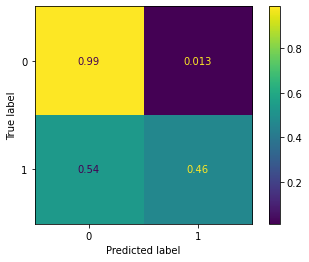

In [ ]:
#Compute baseline F1 Score (and other metrics)

 
print('Accuracy:', accuracy_score(testLabels, testPredict))
print('F1 score:', f1_score(testLabels, testPredict))
print('Recall:', recall_score(testLabels, testPredict))
print('Precision:', precision_score(testLabels, testPredict))
print('\n Clasification report:\n', classification_report(testLabels, testPredict))
print('\n Confusion matrix:\n')
disp = plot_confusion_matrix(lr_clf, vTest, testLabels, normalize='true')

# Brief Exploratory Data Analysis

Let's do a brief data eploratory analysis. Our main goal here is detecting whethere there are human observable patterns that the ML algorithms can pick up with more sofistication. To achieve this, we'll do word clouds for insincere questions (target == 1), and sincere questions (target == 0), and we'll also look at the top 50 words on each class. 

In [168]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib.pyplot import figure
from collections import Counter
# importing NLTK libarary stopwords 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
insincereDF = train[train['target'] == 1]

sincereDF = train[train['target'] == 0]

There are 8005374 words in the combination of all review.


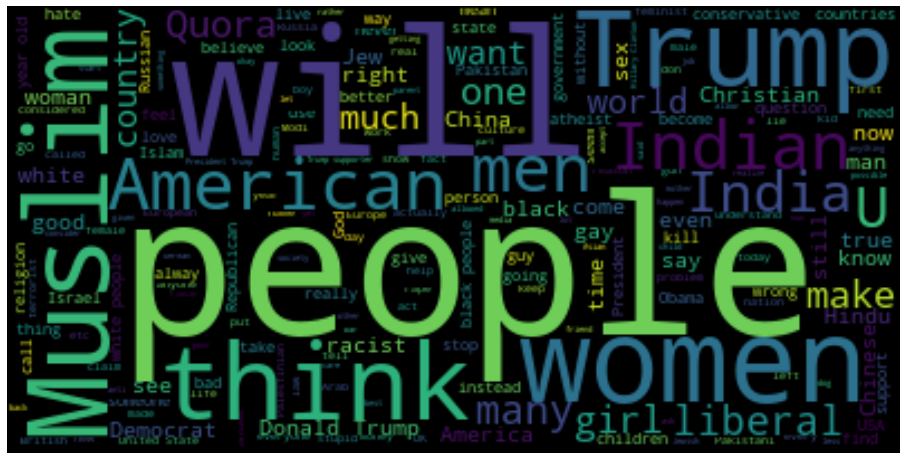

In [ ]:
insincereQWords = " ".join(review for review in insincereDF.question_text)

print ("There are {} words in the combination of all review.".format(len(insincereQWords)))

# Generate a word cloud image
insincereWordCloud = WordCloud(background_color="black").generate(insincereQWords)

# Display the generated image:
figure(figsize=(16, 12))
plt.imshow(insincereWordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

There are 85615928 words in the combination of all review.


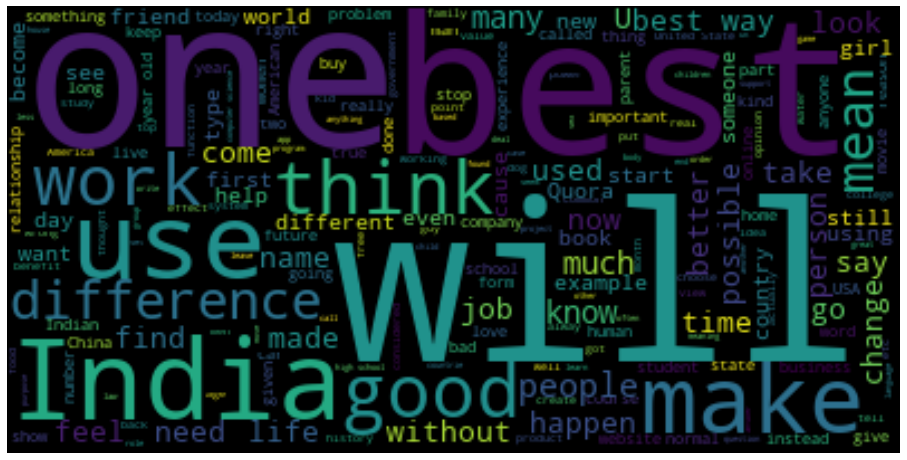

In [ ]:
sincereQWords = " ".join(review for review in sincereDF.question_text)

print ("There are {} words in the combination of all review.".format(len(sincereQWords)))

# Generate a word cloud image
sincereWordCloud = WordCloud(background_color="black").generate(sincereQWords)

# Display the generated image:
figure(figsize=(16, 12))
plt.imshow(sincereWordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [173]:
# split() returns list of all the words in the string
splitItInsincere = insincereQWords.split()
  
# Pass the split_it list to instance of Counter class.
counterInsincere = Counter(splitItInsincere)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
mostOccur = counterInsincere.most_common(1000)

#Create an empty list and append words that ARE NOT in the stop words list 
mostOccurNoStop = []

for item in mostOccur:
  if item[0] not in stopwords.words('english'):
    mostOccurNoStop.append(item)

print(mostOccurNoStop[1:50])

[('I', 11236), ('people', 10869), ('Is', 8396), ('How', 7510), ('What', 6106), ('Do', 5656), ('like', 5638), ('Trump', 4701), ('women', 4639), ('Are', 4611), ('think', 3758), ('If', 3688), ('many', 3471), ('get', 3152), ('would', 3123), ('men', 3047), ('Indian', 2966), ('white', 2914), ('Muslims', 2802), ('Quora', 2541), ('Americans', 2474), ('want', 2332), ('black', 2331), ('hate', 2145), ('Indians', 2104), ('girls', 2067), ('India', 2038), ('sex', 2030), ('make', 1924), ('Chinese', 1833), ('US', 1748), ('Should', 1717), ('liberals', 1707), ('Can', 1685), ('even', 1683), ('Does', 1666), ('Muslim', 1618), ('American', 1614), ('feel', 1568), ('much', 1528), ('one', 1518), ('know', 1507), ('believe', 1486), ('When', 1479), ('Donald', 1478), ('really', 1449), ('say', 1373), ('still', 1350), ('world', 1324)]


In [174]:
# split() returns list of all the words in the string
splitItSincere = sincereQWords.split()
  
# Pass the split_it list to instance of Counter class.
counterSincere = Counter(splitItSincere)
  
# most_common() produces k frequently encountered
# input values and their respective counts.
mostOccur = counterSincere.most_common(1000)
  
#Create an empty list and append words that ARE NOT in the stop words list
mostOccurNoStop = []

for item in mostOccur:
  if item[0] not in stopwords.words('english'):
    mostOccurNoStop.append(item)

print(mostOccurNoStop[1:50])

[('I', 295025), ('How', 254420), ('Why', 109618), ('Is', 100491), ('best', 60794), ('get', 58579), ('Can', 51013), ('would', 48251), ('Which', 46804), ('people', 37448), ('like', 37210), ('good', 34639), ('Do', 34385), ('If', 30869), ('one', 27978), ('make', 25609), ('Are', 24590), ('think', 21599), ('Does', 21514), ('Who', 21130), ('many', 20525), ('much', 20056), ('someone', 19438), ('use', 19201), ('Where', 18720), ('way', 17963), ('know', 17077), ('take', 16696), ('find', 16286), ('ever', 15922), ('want', 15830), ('become', 15758), ('India?', 15527), ('without', 15356), ('Should', 14874), ('time', 14865), ('feel', 14236), ('Will', 13479), ('work', 13245), ('When', 13004), ('go', 12701), ('possible', 12523), ('better', 12457), ("What's", 12121), ("I'm", 12068), ('it?', 11985), ('person', 11985), ('difference', 11921), ('used', 11915)]


### Exploratory Data Analysis Summary: 

There are definitive patterns that are observable by humans and that the ML algorithms can pick up and potentiate. 

If we look at the top 50 list and wordcloud for **insincere questions**, we'll find words that are closely related to people's anxieties and fears over immigration, gender and political affiliations (_e.g. Muslim, Indian, Men, Women, Mexican, Chinese, Girls, Liberals, etc._); we also find words associated to subjective language (_really, many, much_), as well as words that can be associated to incendiary rhetoric (_hate, make, feels_).

If we look at the top 50 list and wordcloud for **sincere questions**, we can't find the patterns described above. Instead, we find plenty of words with a positive connotation (_better, best, can_), and many neutral words (_person, difference, time, should, want, people, can how, why_). The subjective language pattern is also present here (_much, many_).